Phase 1

Importing Libraries

In [38]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
%pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Loading Dataset


In [39]:
dataset = pd.read_csv('breast-cancer.csv')
print(dataset.head())

         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_wor

Data Preprocessing

In [40]:
# 1 Removing the ID column
dataset.drop('id', axis=1, inplace=True)

# 2 checking for missing values
print(dataset.isnull().sum())

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64


In [41]:
# 3 Encoding the categorical data
label_encoder = LabelEncoder()
dataset['diagnosis'] = label_encoder.fit_transform(dataset['diagnosis'])
print(dataset['diagnosis'])

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: diagnosis, Length: 569, dtype: int32


In [42]:
# 4 Feature scaling
features = dataset.columns.drop('diagnosis')
scaler = StandardScaler()
dataset[features] = scaler.fit_transform(dataset[features])
print(dataset.head())

   diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0          1     1.097064     -2.073335        1.269934   0.984375   
1          1     1.829821     -0.353632        1.685955   1.908708   
2          1     1.579888      0.456187        1.566503   1.558884   
3          1    -0.768909      0.253732       -0.592687  -0.764464   
4          1     1.750297     -1.151816        1.776573   1.826229   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0         1.568466          3.283515        2.652874             2.532475   
1        -0.826962         -0.487072       -0.023846             0.548144   
2         0.942210          1.052926        1.363478             2.037231   
3         3.283553          3.402909        1.915897             1.451707   
4         0.280372          0.539340        1.371011             1.428493   

   symmetry_mean  ...  radius_worst  texture_worst  perimeter_worst  \
0       2.217515  ...      1.886690      -1.3

Detecting Outliers

In [43]:
# Calculating the Interquartile Range
Q1 = dataset[features].quantile(0.25)
Q2 = dataset[features].quantile(0.75)
IQR = Q2 - Q1

In [44]:
# Removing the outliers
outliers = dataset[(dataset[features] < (Q1 - 1.5 * IQR)) | (dataset[features] > (Q2 + 1.5 * IQR))].any(axis=1)
cleaned_data = dataset[~outliers]
print(f'Original data size: {len(dataset)}, Cleaned data size: {len(cleaned_data)}')
print('no of outliers:', len(dataset) - len(cleaned_data))

Original data size: 569, Cleaned data size: 398
no of outliers: 171


Visualization

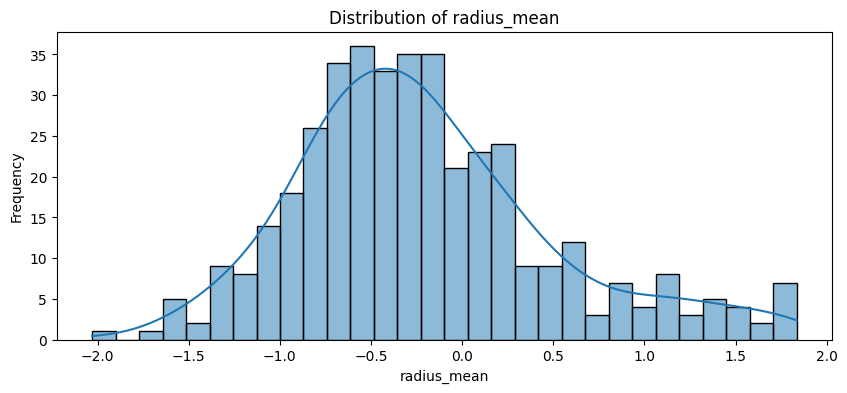

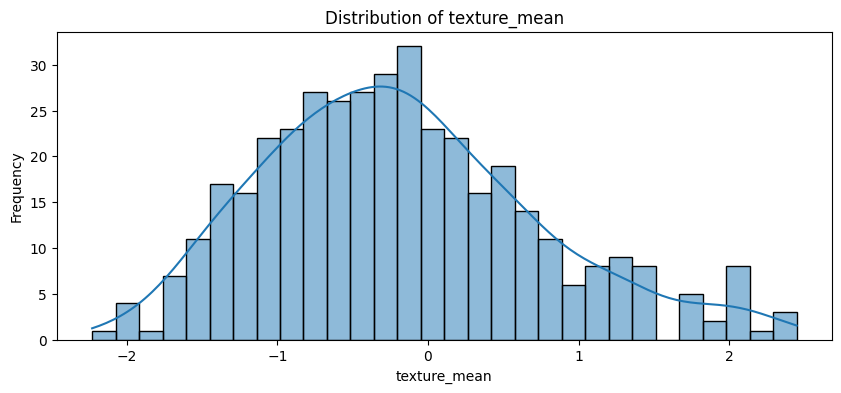

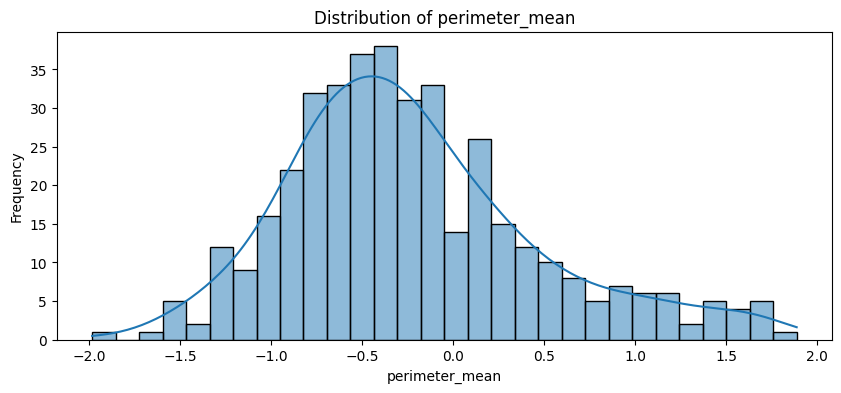

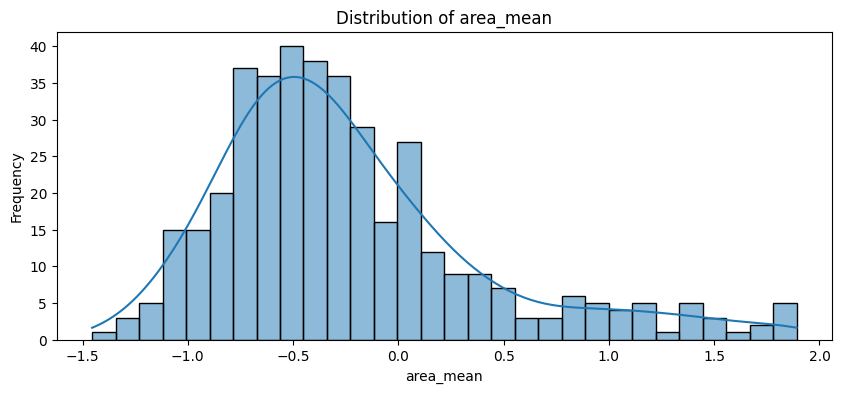

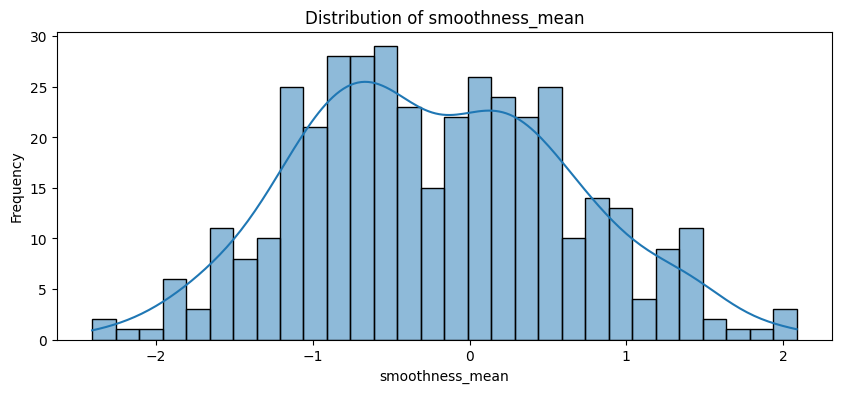

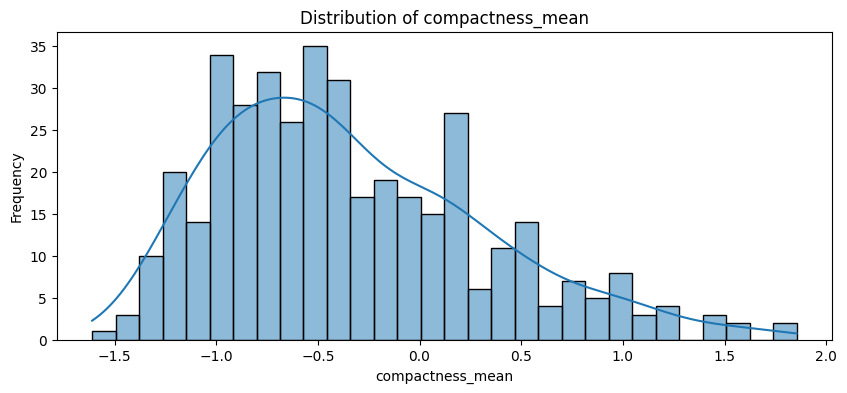

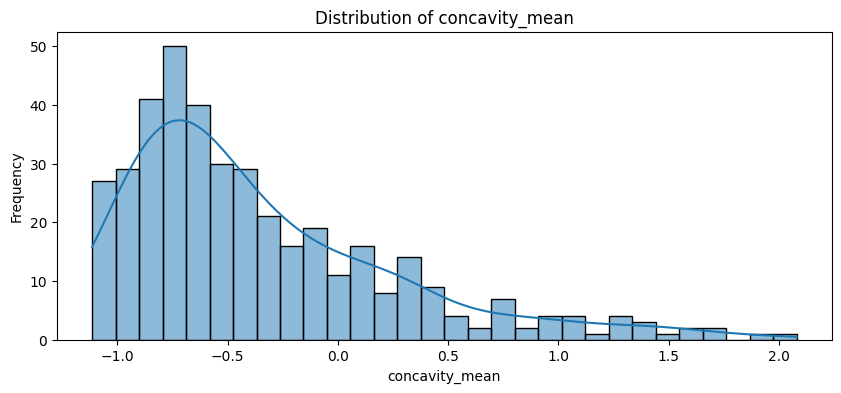

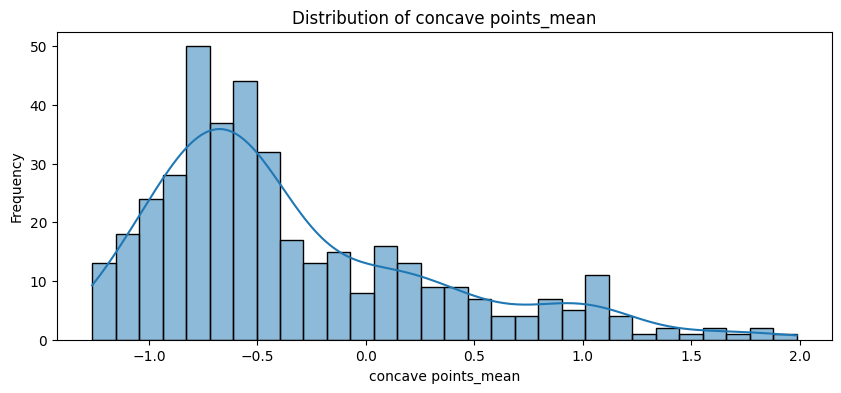

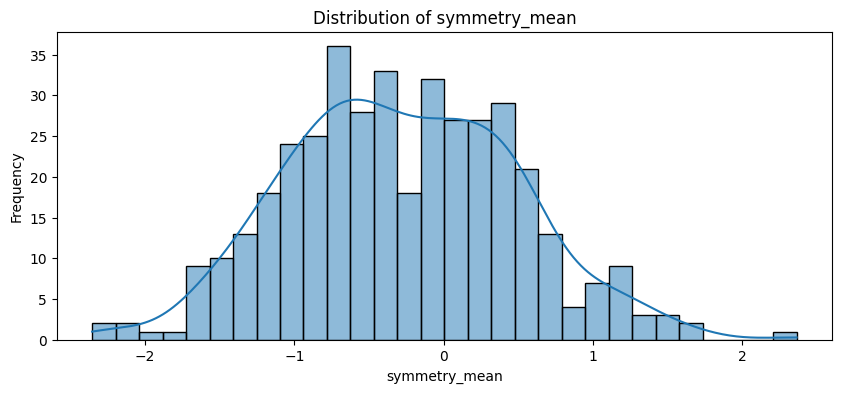

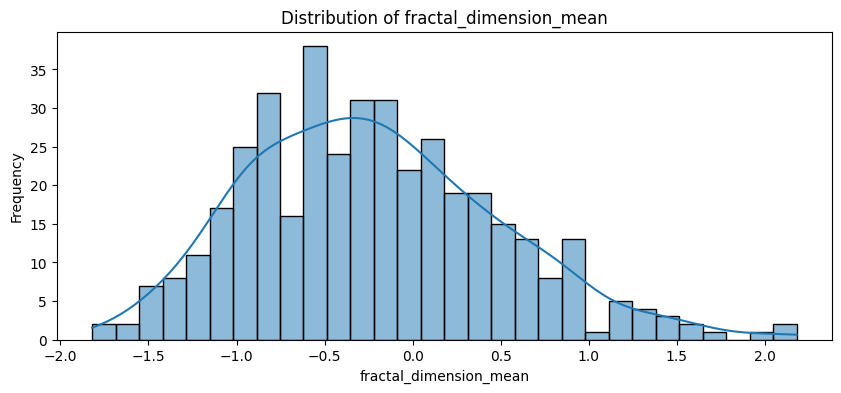

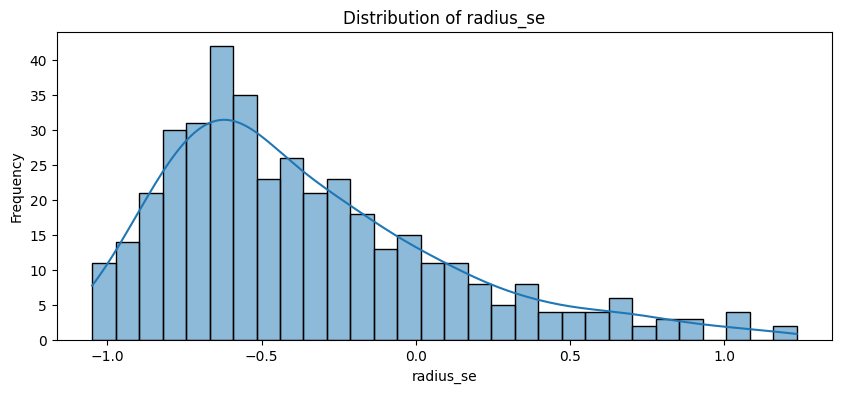

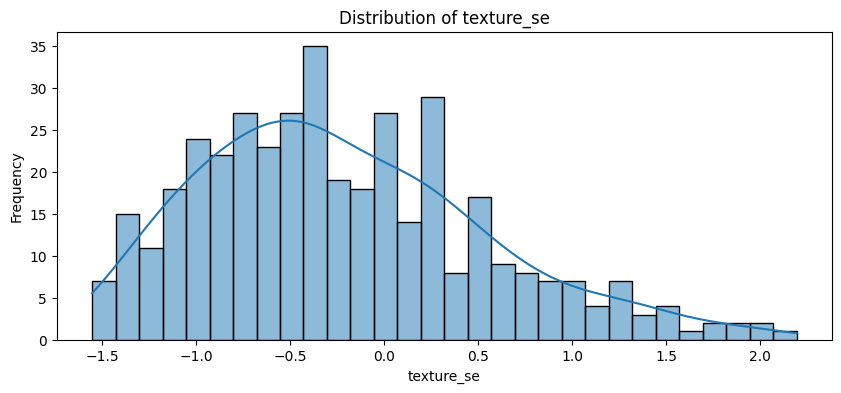

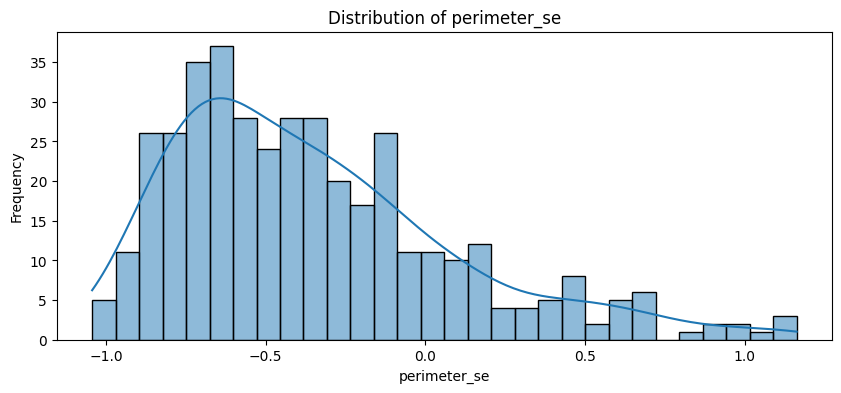

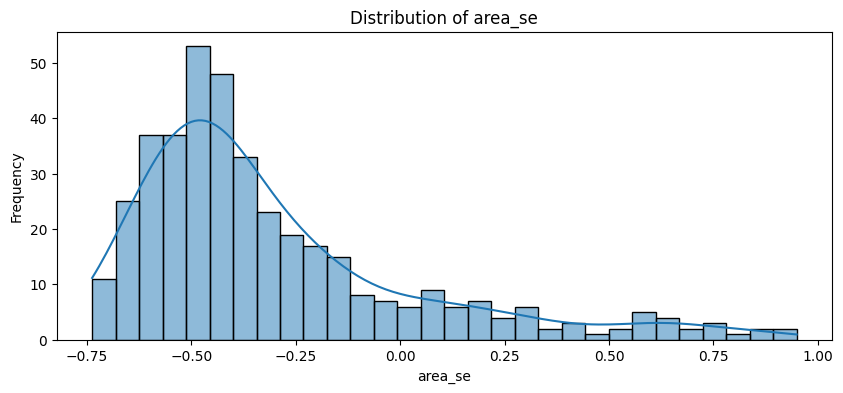

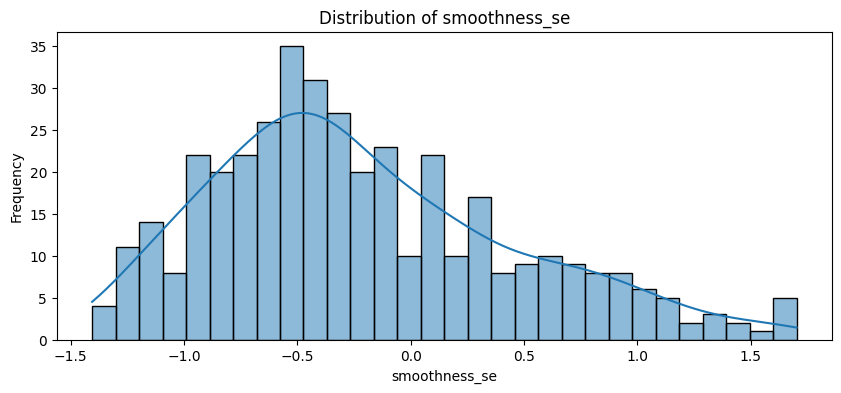

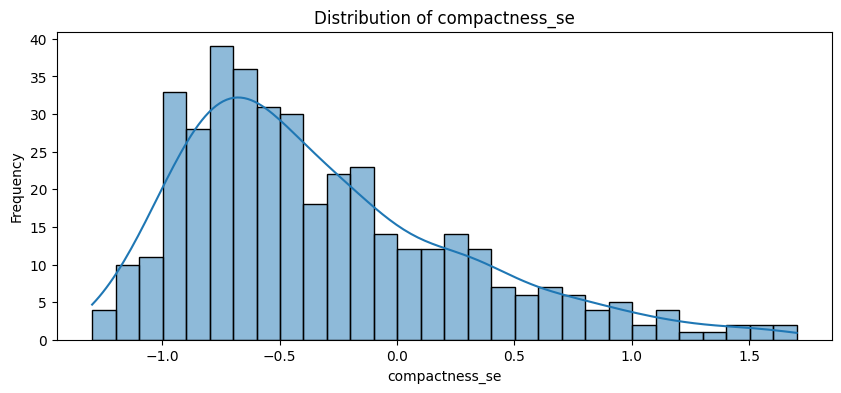

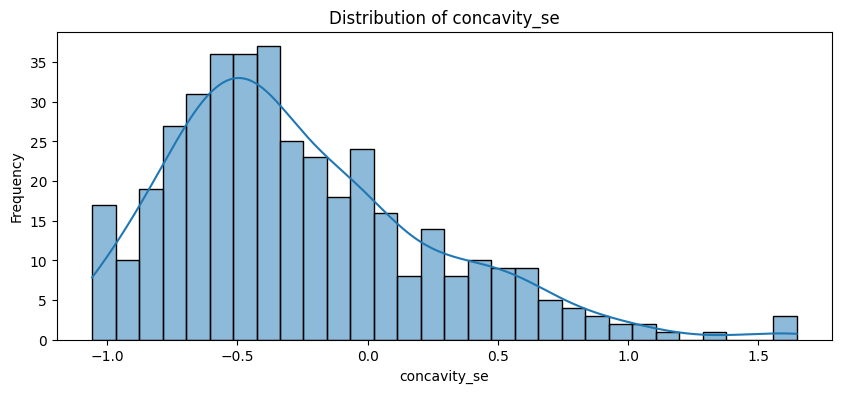

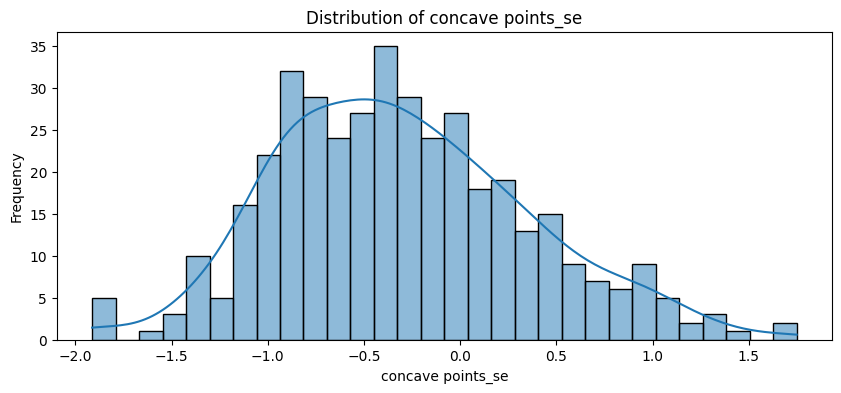

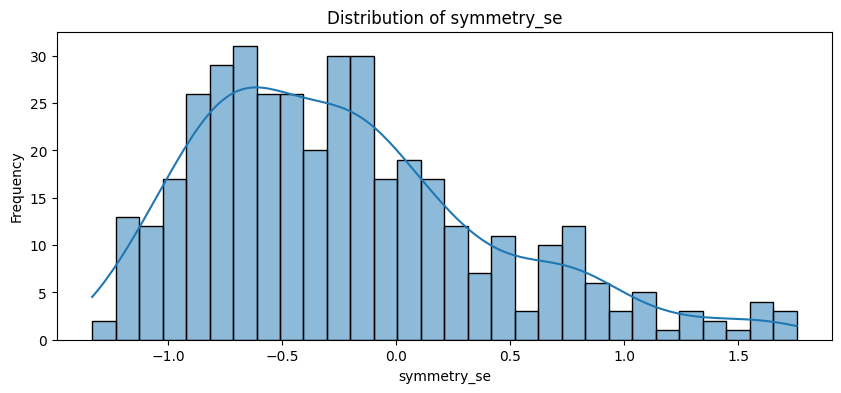

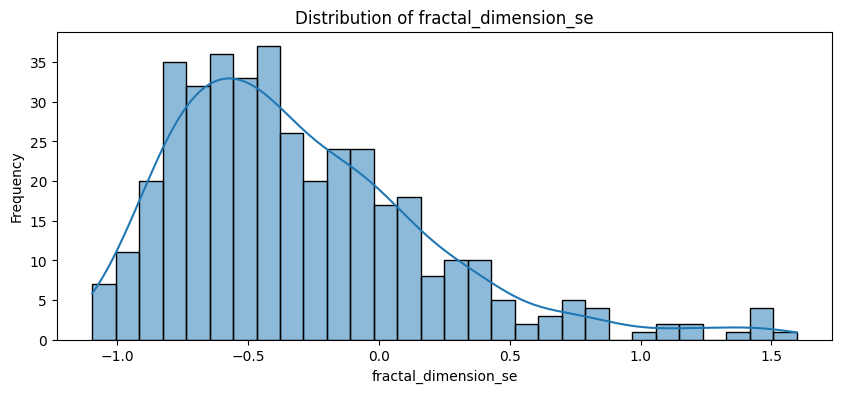

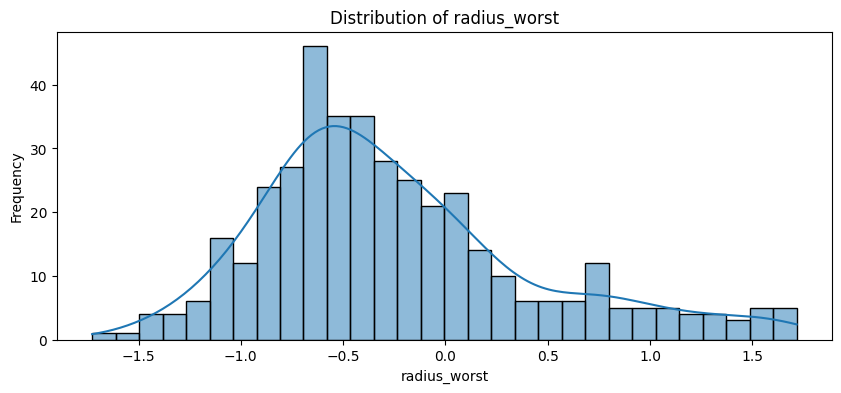

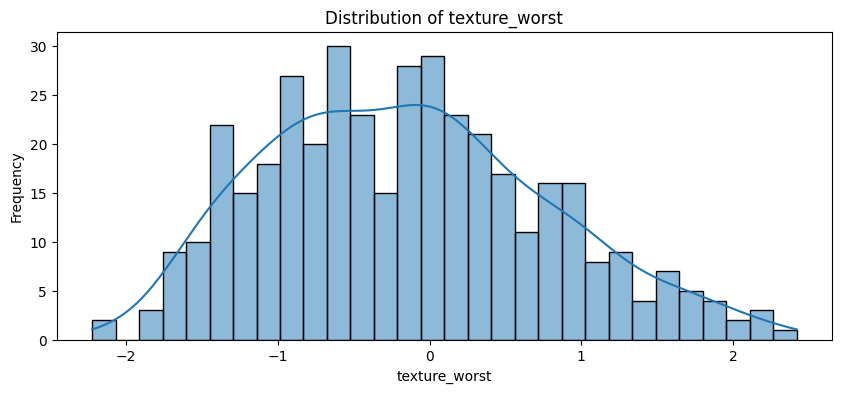

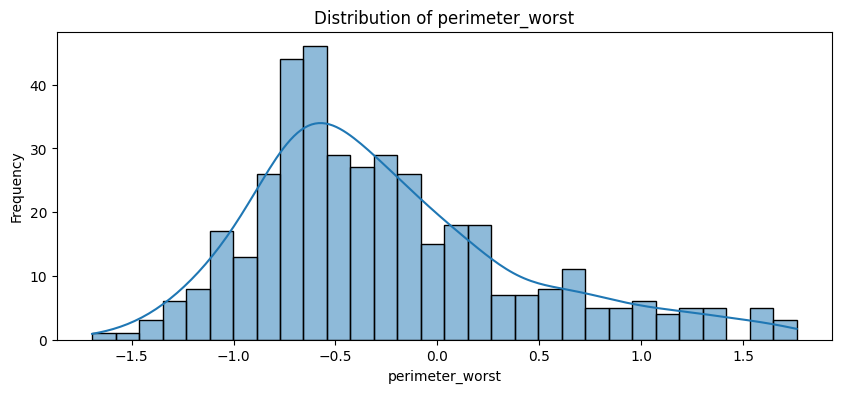

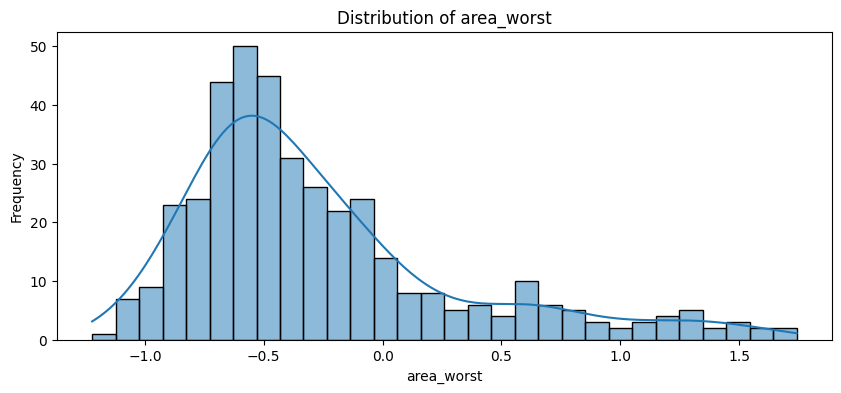

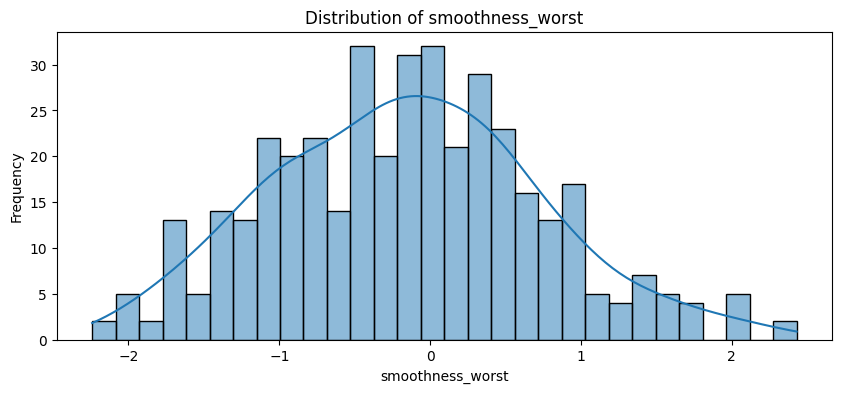

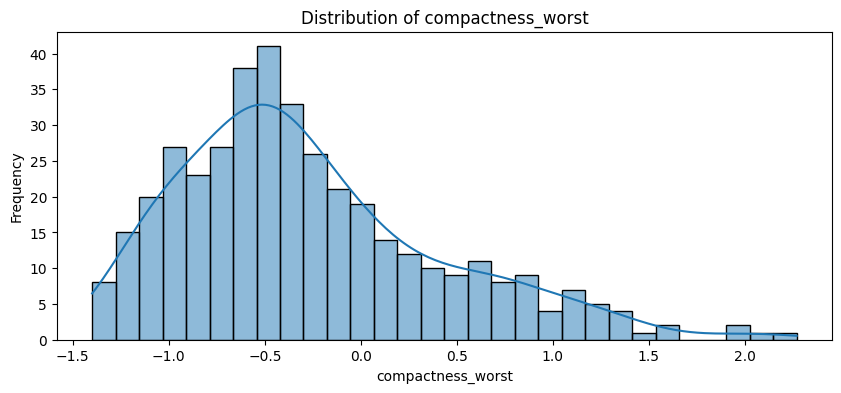

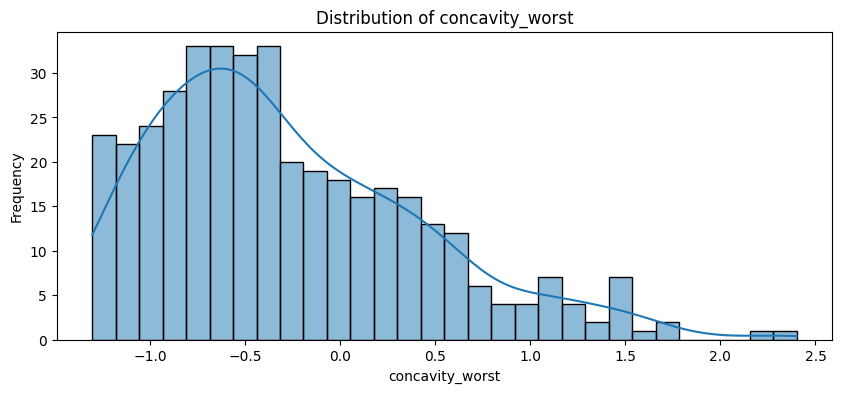

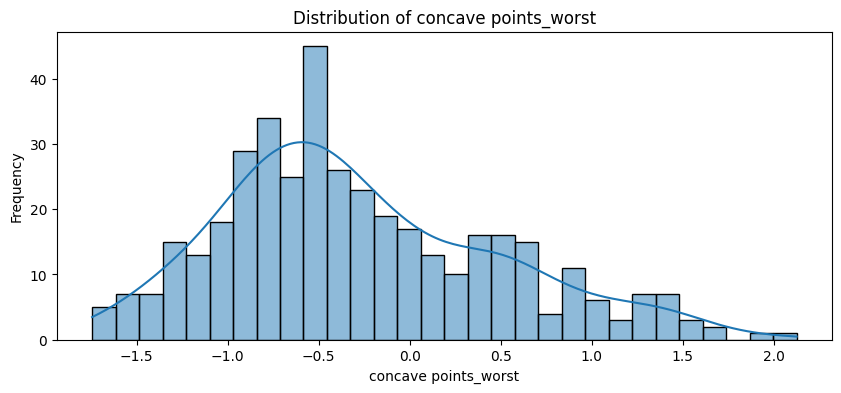

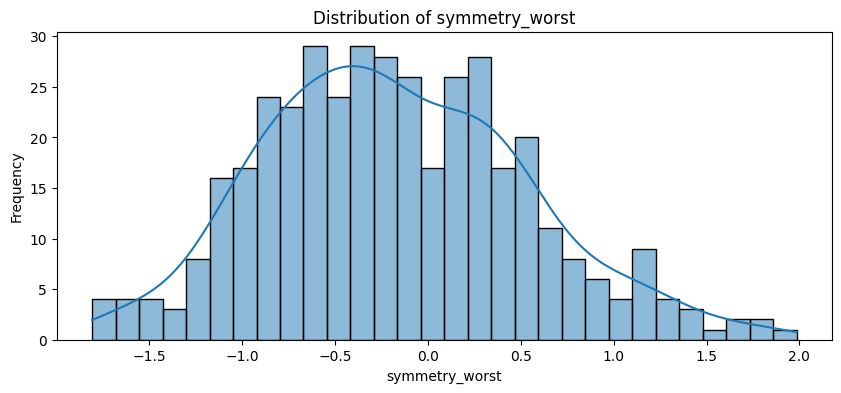

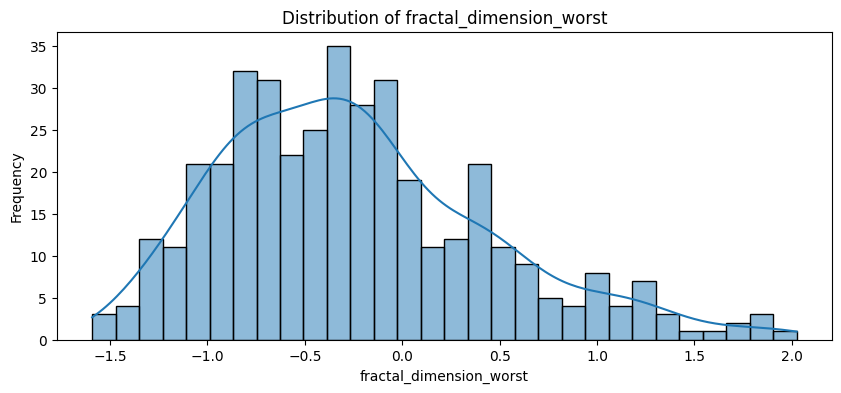

In [45]:
# Visualization of the distribution of features (Histograms for each feature)
for feature in features:
    plt.figure(figsize=(10, 4))
    sns.histplot(cleaned_data[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

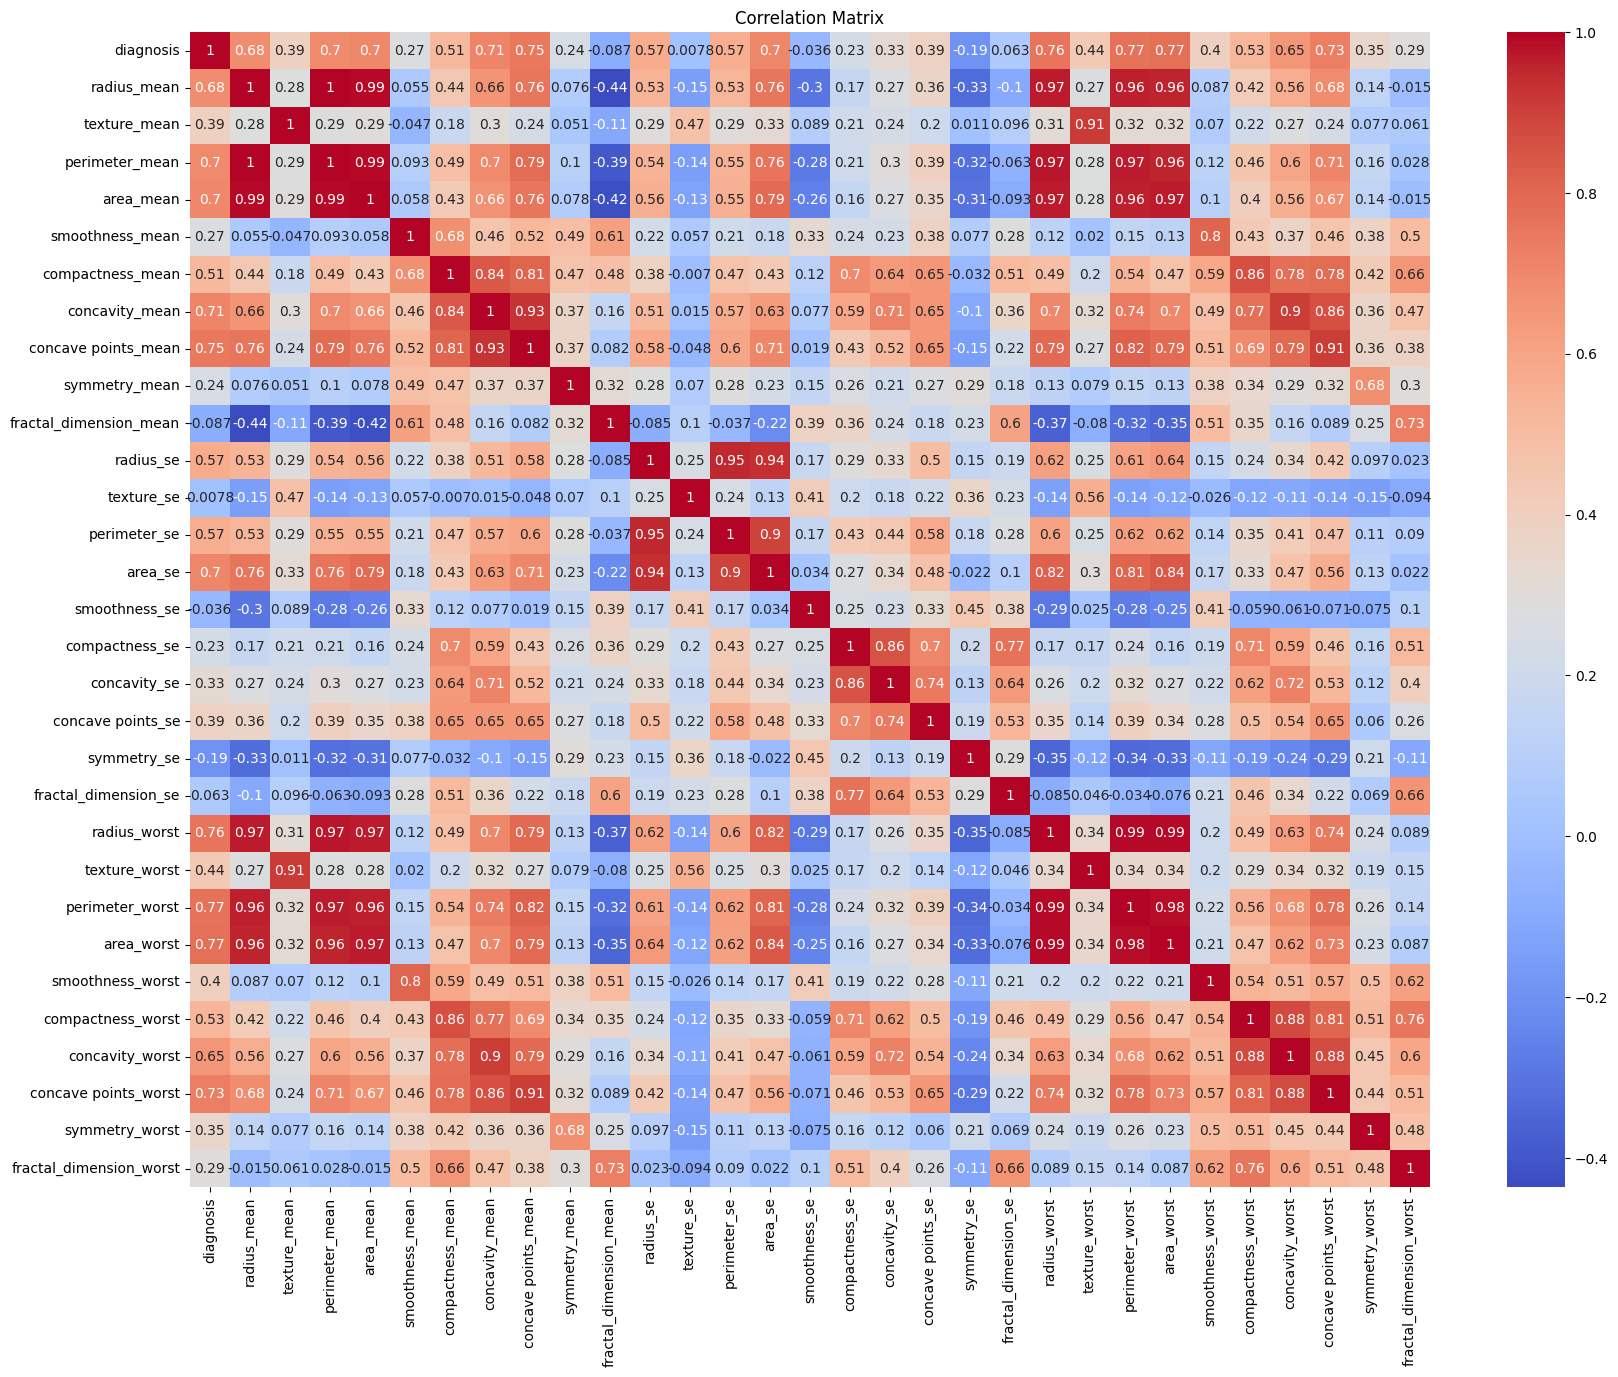

In [46]:
# Visualization of the correlation between features
plt.figure(figsize=(20, 15))
correlation_matrix = cleaned_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

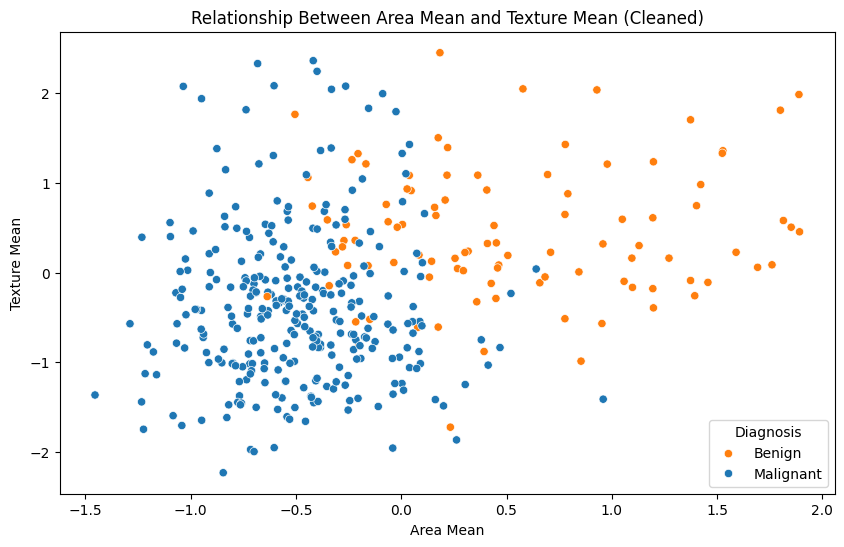

In [47]:
# Scatter plot to visualize relationships between two variables in the cleaned dataset
plt.figure(figsize=(10, 6))
sns.scatterplot(data=cleaned_data, x='area_mean', y='texture_mean', hue='diagnosis')
plt.title('Relationship Between Area Mean and Texture Mean (Cleaned)')
plt.xlabel('Area Mean')
plt.ylabel('Texture Mean')
plt.legend(title='Diagnosis', labels=['Benign', 'Malignant'])
plt.show()


Phase 2

Importing Libraries

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import auc, roc_curve

import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.tree import plot_tree
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay

Splitting the Dataset

In [53]:
X = cleaned_data.drop('diagnosis', axis=1)
y = cleaned_data['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Decision Tree

In [54]:


def train_decision_tree(X_train, X_test, y_train, y_test):
    # Define parameter grid for hyperparameter tuning
    param_grid = {
        'max_depth': [None, 5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Initialize Decision Tree classifier
    clf = DecisionTreeClassifier(random_state=42, criterion='entropy')

    # Initialize GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')

    # Perform hyperparameter tuning
    grid_search.fit(X_train, y_train)

    # Get the best parameters and best estimator
    best_params = grid_search.best_params_
    best_clf = grid_search.best_estimator_

    # Print best parameters
    print("Best Parameters:", best_params)

    # Predict on the test set
    y_pred = best_clf.predict(X_test)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Print performance metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    # Plot ROC curve
    y_pred_proba = best_clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot decision tree
    plt.figure(figsize=(15, 10))
    plot_tree(best_clf, filled=True, feature_names=X_train.columns, class_names=['Benign', 'Malignant'])
    plt.show()

    # Feature importance
    feature_importance = best_clf.feature_importances_
    sorted_indices = np.argsort(feature_importance)[::-1]
    sorted_features = X_train.columns[sorted_indices]
    sorted_importance = feature_importance[sorted_indices]

    plt.figure(figsize=(10, 8))
    sns.barplot(x=sorted_importance, y=sorted_features, palette='viridis')
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title('Feature Importance Plot')
    plt.show()

    # Return best classifier
    return best_clf

Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
Accuracy: 0.9
Precision: 0.9047619047619048
Recall: 0.76
F1 Score: 0.8260869565217391


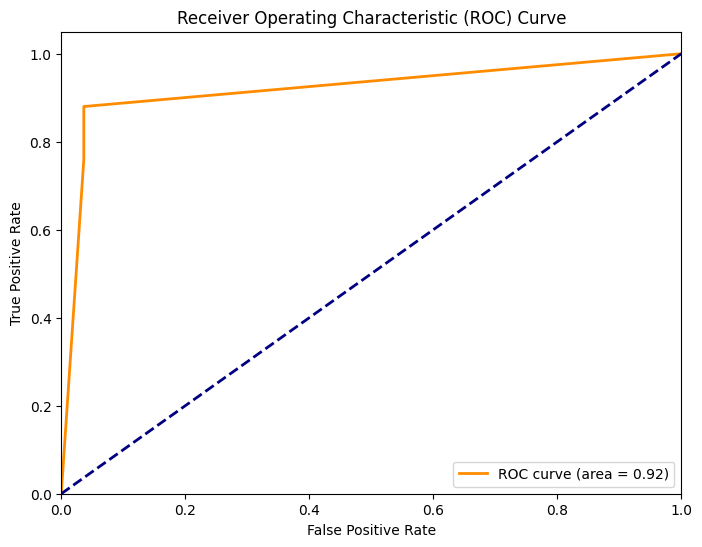

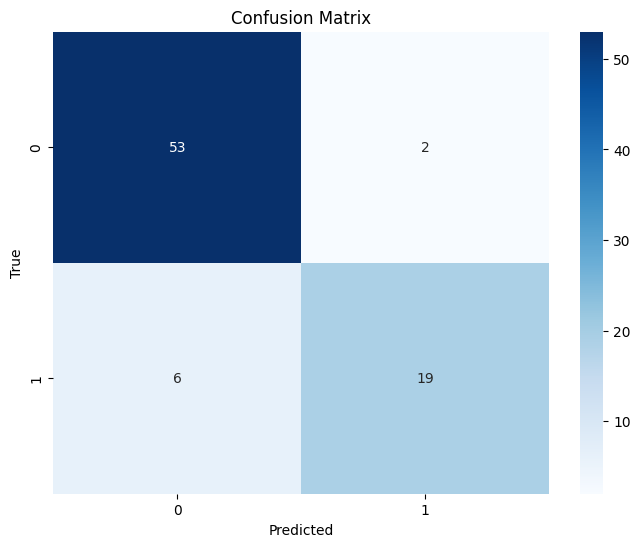

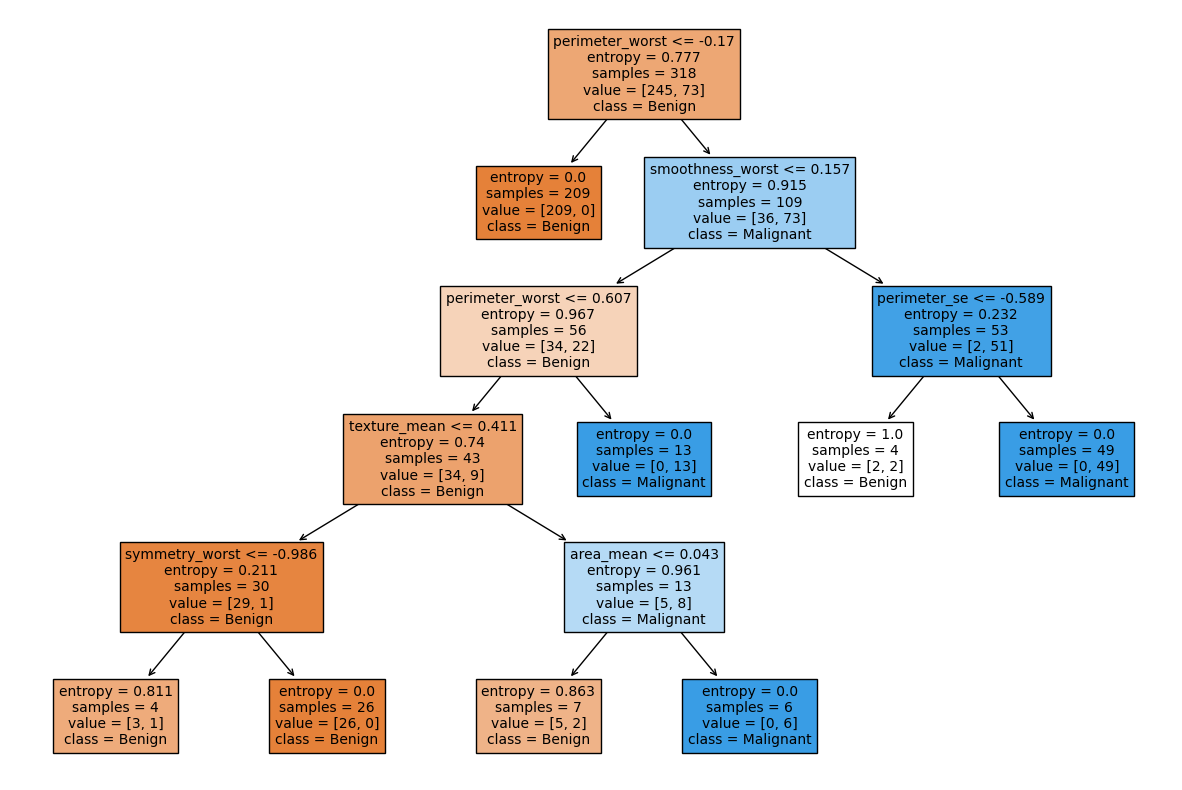

C:\Users\ziada\AppData\Local\Temp\ipykernel_2608\3934949036.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importance, y=sorted_features, palette='viridis')


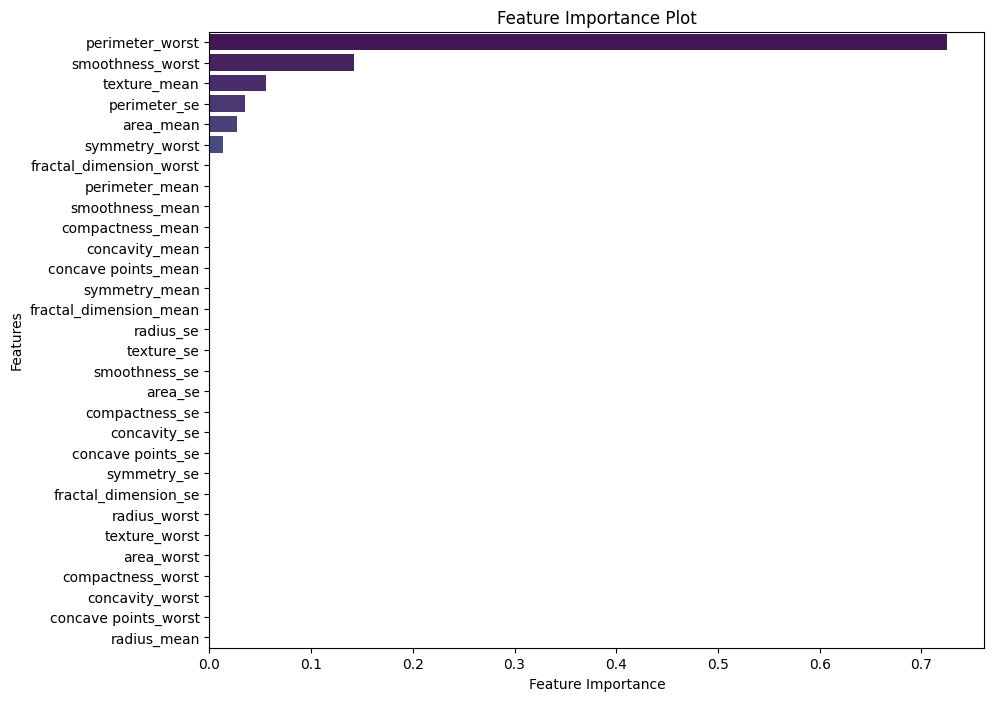

In [55]:
best_clf = train_decision_tree(X_train, X_test, y_train, y_test)

KNN Classifier

In [57]:
def knn(X_train, X_test, y_train, y_test):
    # Define parameter grid for hyperparameter tuning
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'p': [1, 2],
        'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
    }

    # Initialize KNN classifier
    knn = KNeighborsClassifier()

    # Initialize GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

    # Perform hyperparameter tuning
    grid_search.fit(X_train, y_train)

    # Get the best parameters and best estimator
    best_params = grid_search.best_params_
    best_knn = grid_search.best_estimator_

    # Print best parameters
    print("Best Parameters:", best_params)

    # Predict on the test set
    y_pred = best_knn.predict(X_test)

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    tick_marks = np.arange(len(np.unique(y_test)))
    plt.xticks(tick_marks, ['B', 'M'])
    plt.yticks(tick_marks, ['B', 'M'])

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

    # Calculate ROC/AUC
    y_scores = best_knn.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Plot learning curve
    train_sizes, train_scores, test_scores = learning_curve(best_knn, X_train, y_train, cv=5, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

    

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Print performance metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    

    # Return best classifier
    return best_knn, roc_auc

Best Parameters: {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}


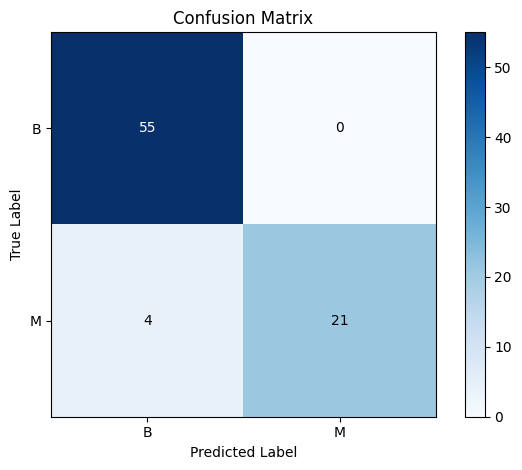

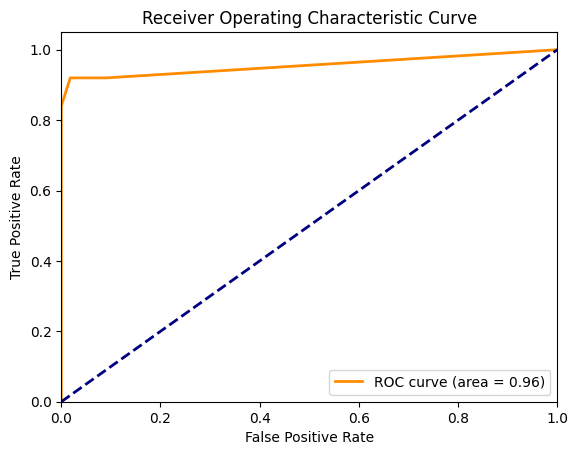

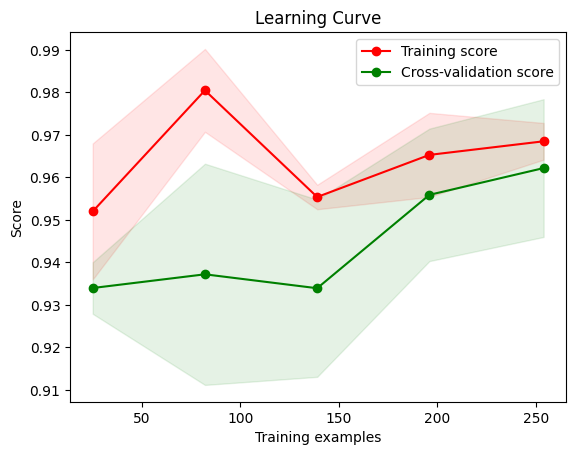

Accuracy: 0.95
Precision: 1.0
Recall: 0.84
F1 Score: 0.9130434782608696


In [58]:
knn_classifier = knn(X_train, X_test, y_train, y_test)

Naive Bayes


In [60]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def train_naive_bayes(X_train, X_test, y_train, y_test):
   

    # Initialize Gaussian Naive Bayes classifier
    nb_classifier = GaussianNB()

    # Train the classifier
    nb_classifier.fit(X_train, y_train)

    # Predict on the test set
    y_pred = nb_classifier.predict(X_test)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

     # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    tick_marks = np.arange(len(np.unique(y_test)))
    plt.xticks(tick_marks, ['Benign', 'Malignant'])
    plt.yticks(tick_marks, ['Benign', 'Malignant'])

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

    labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    values = [accuracy, precision, recall, f1]

    plt.figure(figsize=(8, 6))
    plt.bar(labels, values, color=['blue', 'green', 'red', 'purple'])
    plt.title('Performance Metrics')
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
    plt.show()
    # Print performance metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    

    # Return trained classifier
    return nb_classifier



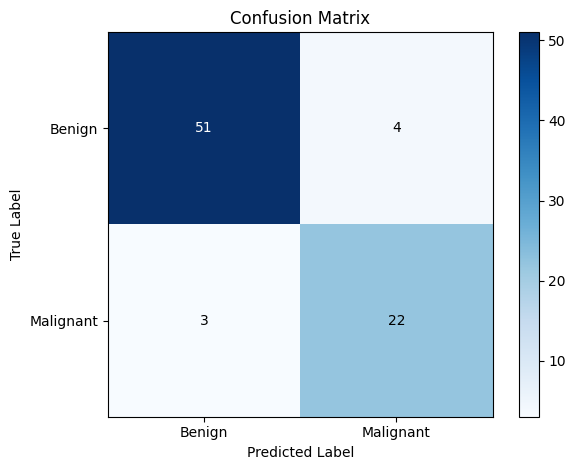

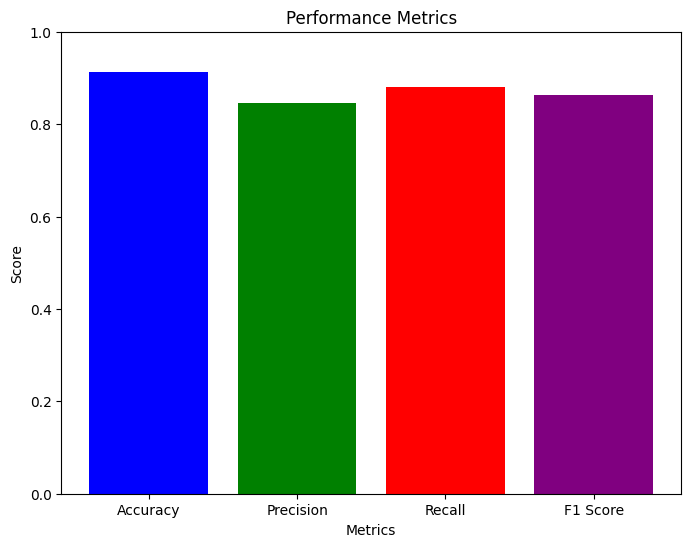

Accuracy: 0.9125
Precision: 0.8461538461538461
Recall: 0.88
F1 Score: 0.8627450980392156


In [61]:
nb_classifier = train_naive_bayes(X_train, X_test, y_train, y_test)


SVM

In [62]:
from sklearn.svm import SVC


def svm(X_train, X_test, y_train, y_test):
    # Define parameter grid for hyperparameter tuning
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': [1, 0.1, 0.01, 0.001],
        'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
    }

    # Initialize SVM classifier
    svm_classifier = SVC()

    # Initialize GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(svm_classifier, param_grid, cv=5, scoring='accuracy')

    # Perform hyperparameter tuning
    grid_search.fit(X_train, y_train)

    # Get the best parameters and best estimator
    best_params = grid_search.best_params_
    best_svm = grid_search.best_estimator_

    # Print best parameters
    print("Best Parameters:", best_params)

    # Predict on the test set
    y_pred = best_svm.predict(X_test)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Print performance metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    
       # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    tick_marks = np.arange(len(np.unique(y_test)))
    plt.xticks(tick_marks, ['B', 'M'])
    plt.yticks(tick_marks, ['B', 'M'])

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.show()
    # Return best classifier
    return best_svm



Best Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Accuracy: 0.9625
Precision: 1.0
Recall: 0.88
F1 Score: 0.9361702127659575


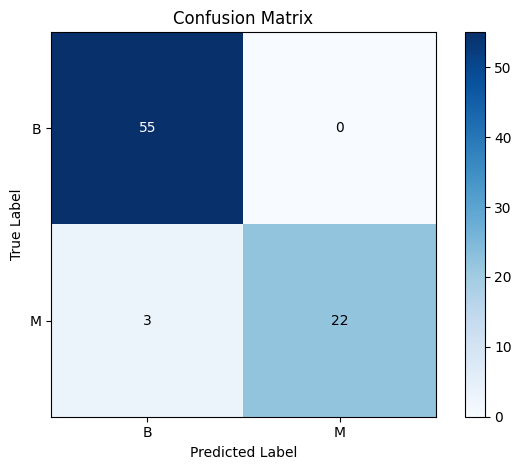

In [63]:
svm_classifier = svm(X_train, X_test, y_train, y_test)
